In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

 
# ==============================
# STEP 1: Load Data
# ==============================
df = pd.read_csv('/finalproject/cleaning_process/hospital_data_cleaned.csv')
df['ResidentDate'] = pd.to_datetime(df['ResidentDate'])
 
# ==============================
# STEP 2: Process Pandemic and Disaster Flags
# ==============================
# Convert pandemic to binary flag (1 for Covid_Wave, 0 for None)
df['pandemic_flag'] = (df['pandemic'] == 'Covid_Wave').astype(int)
 
df['disaster'] = df['disaster'].fillna('None')  
# Convert disaster to binary flag (1 for any disaster, 0 for None)
df['disaster_flag'] = (df['disaster'] != 'None').astype(int)
 
# ==============================
# STEP 3: Aggregate to Daily Level (Unique Dates)
# ==============================
# Group by date to ensure one row per day
daily_df = df.groupby('ResidentDate').agg({
    'DischargeFromED': 'sum',          # Total daily discharges
    'temperature_max': 'max',          # Daily max temp
    'temperature_min': 'min',          # Daily min temp
    'precipitation': 'sum',            # Total daily precipitation
    'event_type': lambda x: x.mode()[0] if len(x.mode()) > 0 else "No Event",  # Most frequent event
    'pandemic_flag': 'max',            # 1 if any record that day was pandemic
    'disaster_flag': 'max'             # 1 if any record that day was disaster
}).reset_index()
 
# ==============================
# STEP 4: Feature Engineering (Daily Level)
# ==============================
# Time features
daily_df['ResidentDate_year'] = daily_df['ResidentDate'].dt.year
daily_df['ResidentDate_month'] = daily_df['ResidentDate'].dt.month
daily_df['ResidentDate_day'] = daily_df['ResidentDate'].dt.day
daily_df['ResidentDate_weekday'] = daily_df['ResidentDate'].dt.weekday
daily_df['is_weekend'] = daily_df['ResidentDate_weekday'].isin([5, 6]).astype(int)
daily_df['season'] = daily_df['ResidentDate_month'] % 12 // 3 + 1
 
# Weather features
daily_df['temp_range'] = daily_df['temperature_max'] - daily_df['temperature_min']
daily_df['is_rain'] = (daily_df['precipitation'] > 0).astype(int)
 
# Event features (renamed to Festival)
daily_df['Festival'] = (daily_df['event_type'] != "No Event").astype(int)
 
# ==============================
# STEP 5: Lag/Rolling Features (Daily)
# ==============================
daily_df = daily_df.sort_values('ResidentDate')
 
# Rename DischargeFromED to Total_Admissions
daily_df = daily_df.rename(columns={'DischargeFromED': 'Total_Admissions'})
 
# Lag features
daily_df['Total_Admissions_Lag1'] = daily_df['Total_Admissions'].shift(1)
daily_df['Total_Admissions_Lag7'] = daily_df['Total_Admissions'].shift(7)
 
# Rolling stats
daily_df['Total_Admissions_MA7'] = daily_df['Total_Admissions'].rolling(window=7).mean()
daily_df['Total_Admissions_MA14'] = daily_df['Total_Admissions'].rolling(window=14).mean()
daily_df['Total_Admissions_EMA'] = daily_df['Total_Admissions'].ewm(span=7, adjust=False).mean()
daily_df['Total_Admissions_Rolling_Std'] = daily_df['Total_Admissions'].rolling(window=7).std()
daily_df['Total_Admissions_Rolling_Min'] = daily_df['Total_Admissions'].rolling(window=7).min()
daily_df['Total_Admissions_Rolling_Max'] = daily_df['Total_Admissions'].rolling(window=7).max()
 
# Fill NaNs (first 7 days won't have rolling stats)
daily_df.fillna(method='bfill', inplace=True)
 
# ==============================
# STEP 6: Save Final Dataset
# ==============================
columns_to_keep = [
    "ResidentDate",
    "Total_Admissions",
    "ResidentDate_year", "ResidentDate_month", "ResidentDate_day",
    "ResidentDate_weekday", "is_weekend", "season",
    "temperature_max", "temperature_min", "temp_range", "precipitation", "is_rain",
    "Festival", "pandemic_flag", "disaster_flag",
    "Total_Admissions_Lag1", "Total_Admissions_Lag7",
    "Total_Admissions_MA7", "Total_Admissions_MA14", "Total_Admissions_EMA",
    "Total_Admissions_Rolling_Std", "Total_Admissions_Rolling_Min", "Total_Admissions_Rolling_Max"
]
 
daily_df[columns_to_keep].to_csv("/finalproject/feature_engineering/time_series_data.csv", index=False)
 

C:\Users\TottaraDhanush\AppData\Local\Temp\ipykernel_11104\1916541931.py:4: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/finalproject/cleaning_process/hospital_data_cleaned.csv')
C:\Users\TottaraDhanush\AppData\Local\Temp\ipykernel_11104\1916541931.py:70: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_df.fillna(method='bfill', inplace=True)


In [5]:
df= pd.read_csv('/finalproject/feature_engineering/classification_data.csv')

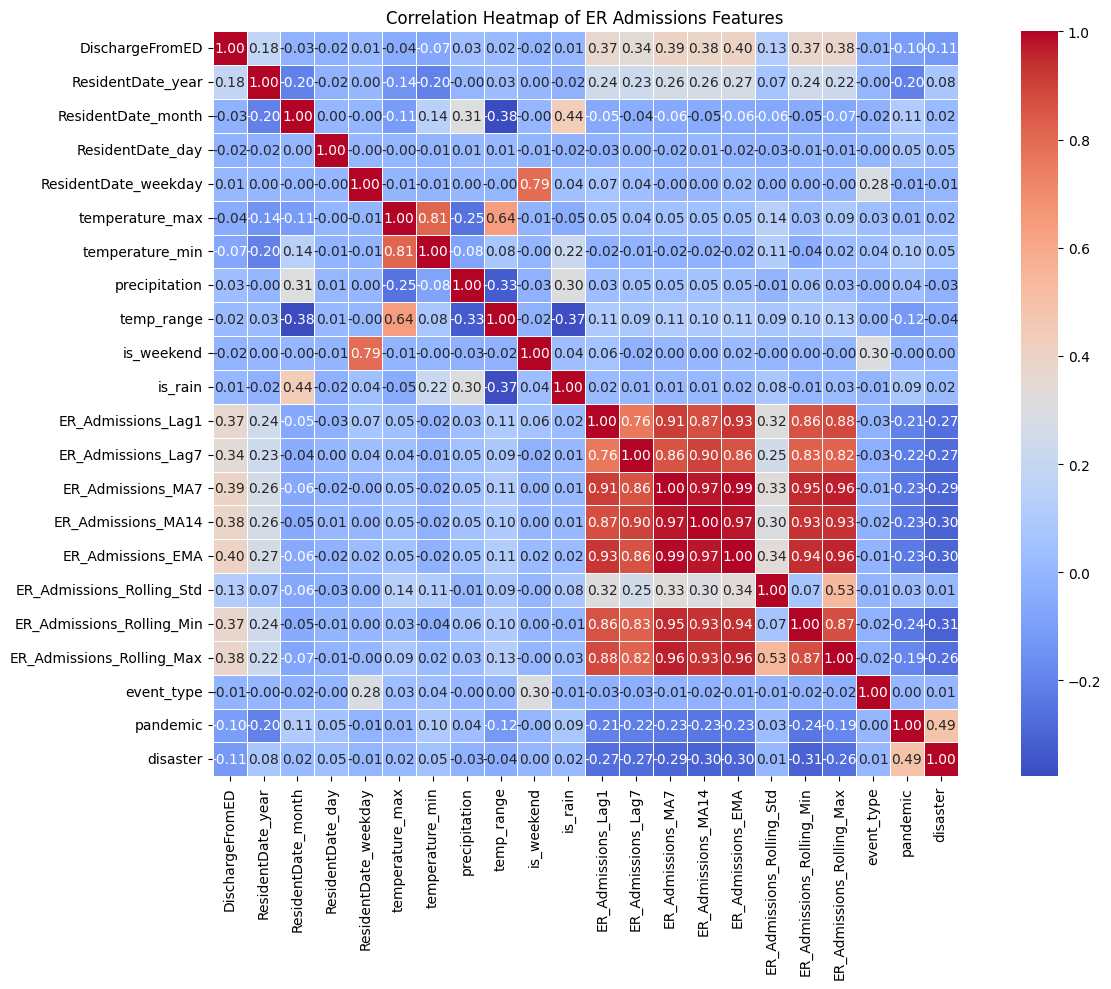

In [6]:
# Select relevant columns for correlation
numeric_cols = [
    'DischargeFromED', 'ResidentDate_year', 'ResidentDate_month', 'ResidentDate_day',
    'ResidentDate_weekday', 'temperature_max', 'temperature_min', 'precipitation', 'temp_range',
    'is_weekend', 'is_rain', 'ER_Admissions_Lag1', 'ER_Admissions_Lag7', 'ER_Admissions_MA7',
    'ER_Admissions_MA14', 'ER_Admissions_EMA', 'ER_Admissions_Rolling_Std',
    'ER_Admissions_Rolling_Min', 'ER_Admissions_Rolling_Max'
]

# Convert event_type, pandemic, and disaster to numerical values
df['event_type'] = df['event_type'].astype('category').cat.codes
df['pandemic'] = df['pandemic'].astype('category').cat.codes
df['disaster'] = df['disaster'].astype('category').cat.codes

# Add them to numeric_cols for heatmap
numeric_cols += ['event_type', 'pandemic', 'disaster']

# Compute the correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Heatmap of ER Admissions Features")
plt.tight_layout()
plt.show()

In [3]:
print(daily_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ResidentDate                  1819 non-null   datetime64[ns]
 1   Total_Admissions              1819 non-null   int64         
 2   temperature_max               1819 non-null   float64       
 3   temperature_min               1819 non-null   float64       
 4   precipitation                 1819 non-null   float64       
 5   event_type                    1819 non-null   object        
 6   pandemic_flag                 1819 non-null   int64         
 7   disaster_flag                 1819 non-null   int64         
 8   ResidentDate_year             1819 non-null   int32         
 9   ResidentDate_month            1819 non-null   int32         
 10  ResidentDate_day              1819 non-null   int32         
 11  ResidentDate_weekday          

In [4]:
daily_df.nunique()

ResidentDate                    1819
Total_Admissions                  99
temperature_max                  147
temperature_min                  118
precipitation                    889
event_type                         3
pandemic_flag                      2
disaster_flag                      2
ResidentDate_year                  6
ResidentDate_month                12
ResidentDate_day                  31
ResidentDate_weekday               7
is_weekend                         2
season                             4
temp_range                       201
is_rain                            2
Festival                           2
Total_Admissions_Lag1             99
Total_Admissions_Lag7             99
Total_Admissions_MA7             472
Total_Admissions_MA14            702
Total_Admissions_EMA            1819
Total_Admissions_Rolling_Std    1736
Total_Admissions_Rolling_Min      72
Total_Admissions_Rolling_Max      88
dtype: int64